<a href="https://colab.research.google.com/github/nimamt/machine_learning/blob/master/tf/Projects/Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pima Indians Diabetes Database

https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

## Data Analysis + Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
! pip install kaggle
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download uciml/pima-indians-diabetes-database

  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 8.15MB/s]


In [4]:
! unzip -o pima-indians-diabetes-database.zip

Archive:  pima-indians-diabetes-database.zip
  inflating: diabetes.csv            


In [5]:
df = pd.read_csv('/content/diabetes.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


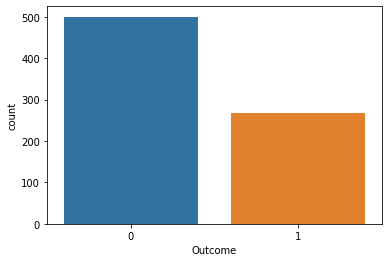

In [7]:
sns.countplot(df['Outcome'])

In [8]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Neural Model

In [9]:
X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=101)

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

In [13]:
X_train.shape[1:]

(8,)

In [14]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(y_train),
                                                 y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

class_weights

{0: 0.7732997481108312, 1: 1.4147465437788018}

In [15]:
from tensorflow.keras.metrics import Precision,Recall

class F1_Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = Precision(thresholds=0.5)
        self.recall_fn = Recall(thresholds=0.5)

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        # since f1 is a variable, we use assign
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        return self.f1

    def reset_state(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_state()
        self.recall_fn.reset_state()
        self.f1.assign(0)

In [18]:
model = Sequential()

model.add(keras.layers.Input(shape=X_train.shape[1:]))

model.add(Dense(5, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[F1_Score()])

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_f1_score',
                           mode='max', verbose=1, patience= 30)

In [24]:
model.fit(x=X_train, y=y_train, epochs=600, batch_size=2,
          validation_data=(X_test,y_test), class_weight=class_weights)

Epoch 1/600
307/307 [==============================] - 1s 4ms/step - loss: 0.6423 - f1_score: 0.5468 - val_loss: 0.6121 - val_f1_score: 0.6094
Epoch 2/600
307/307 [==============================] - 1s 5ms/step - loss: 0.6439 - f1_score: 0.5539 - val_loss: 0.6011 - val_f1_score: 0.5641
Epoch 3/600
307/307 [==============================] - 1s 3ms/step - loss: 0.6493 - f1_score: 0.5291 - val_loss: 0.6061 - val_f1_score: 0.6400
Epoch 4/600
307/307 [==============================] - 1s 3ms/step - loss: 0.6294 - f1_score: 0.5907 - val_loss: 0.6054 - val_f1_score: 0.6357
Epoch 5/600
307/307 [==============================] - 1s 3ms/step - loss: 0.6386 - f1_score: 0.5630 - val_loss: 0.5958 - val_f1_score: 0.6290
Epoch 6/600
307/307 [==============================] - 1s 3ms/step - loss: 0.6203 - f1_score: 0.6039 - val_loss: 0.5993 - val_f1_score: 0.6119
Epoch 7/600
307/307 [==============================] - 1s 3ms/step - loss: 0.6248 - f1_score: 0.5676 - val_loss: 0.5882 - val_f1_score: 0.6154

In [25]:
predictions = model.predict(X_test)

predictions = (model.predict(X_test) > 0.5).astype("int32")

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[86 17]
 [15 36]]


              precision    recall  f1-score   support

           0       0.85      0.83      0.84       103
           1       0.68      0.71      0.69        51

    accuracy                           0.79       154
   macro avg       0.77      0.77      0.77       154
weighted avg       0.79      0.79      0.79       154



In [30]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=10,n_estimators=500,class_weight=class_weights)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

print(confusion_matrix(y_test,rfc_pred))
print('\n')
print(classification_report(y_test,rfc_pred))

[[84 19]
 [20 31]]


              precision    recall  f1-score   support

           0       0.81      0.82      0.81       103
           1       0.62      0.61      0.61        51

    accuracy                           0.75       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.75      0.75      0.75       154

